In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pesq import pesq
import pystoi
from scipy.signal import lfilter, wiener
from tqdm import tqdm

from utils import load_wav, calculate_snr, itakura_distortion
from sound import Sound
from batch import DataGenerator

In [3]:
base_shape_size = 8000

In [4]:
# carrega sons de ruido e sons de voz
sound_base = Sound('../Dados/Base/', '../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:09<00:00, 221.57it/s]


In [5]:
data_generator = DataGenerator(sound_base.train_X, sound_base.noise_sounds)

In [6]:
def wiener_filter(noisy_signal, snr_db):
    """
    Aplica o filtro de Wiener para remover ruído de um sinal ruidoso.

    Args:
        noisy_signal (numpy array): O sinal de voz ruidoso.
        snr_db (float): Relação sinal-ruído (SNR) desejada em dB.

    Returns:
        filtered_signal (numpy array): O sinal filtrado.
    """
    # Calcule a potência do sinal ruidoso
    signal_power = np.mean(noisy_signal ** 2)

    # Calcule a potência do ruído com base na relação sinal-ruído desejada em dB
    noise_power = signal_power / (10 ** (snr_db / 10))

    filtered_signal = wiener(noisy_signal.astype('float32'), mysize=10)

    return filtered_signal

In [9]:
batch_num = 1
window_size = 250
order = 11
df_resultado = pd.DataFrame()

In [10]:
for _ in tqdm(range(batch_num)):
    x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_metrics(window_size, order, batch_size=128))
                
    # Aplica o filtro de Wiener aos sinais ruidosos
    filtered_batch = [wiener_filter(noisy_signal, snr) for noisy_signal, snr in zip(x_batch, metrics_batch_df['SNR'])]
    
    # Calcula as métricas para os sinais filtrados
    pesq_scores = [pesq(8000, clean, filtered.reshape(-1), 'nb') for clean, filtered in zip(y_batch, filtered_batch)]
    stoi_scores = [pystoi.stoi(clean, filtered, 8000) for clean, filtered in zip(y_batch, filtered_batch)]
    snr_scores = [calculate_snr(clean, filtered) for clean, filtered in zip(y_batch, filtered_batch)]
    ID_scores = [itakura_distortion(clean, filtered, window_size, order) for clean, filtered in zip(y_batch, filtered_batch)]
    
    # Adiciona as métricas dos sinais filtrados ao DataFrame
    metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    metrics_batch_df['STOI (Filtered)'] = stoi_scores
    metrics_batch_df['SNR (Filtered)'] = snr_scores
    metrics_batch_df['ID (Filtered)'] = ID_scores

    df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.8/dist-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
100%|██████████| 1/1 [00:12<00:00, 12.61s/it]


In [11]:
df_resultado.shape

(128, 10)

In [12]:
df_resultado

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
0,19.0,15.0,2.267531,0.888765,13.524187,0.124784,2.361527,0.872237,13.141814,0.184066
1,14.0,22.0,2.205184,0.913407,13.343101,0.039941,1.492095,0.780537,10.304396,0.217097
2,4.0,20.0,2.187483,0.826488,3.882030,-0.034730,2.002758,0.856793,5.186089,-0.059611
3,5.0,23.0,1.602774,0.744774,5.386001,0.552531,1.413752,0.674854,6.087227,0.364077
4,2.0,21.0,2.077904,0.911314,1.929148,0.999026,2.289218,0.856693,9.673509,0.178392
...,...,...,...,...,...,...,...,...,...,...
123,0.0,21.0,2.377935,0.937534,-0.048050,0.552714,2.809597,0.920703,0.167829,0.104113
124,16.0,23.0,3.001925,0.968031,15.181855,0.048134,2.811989,0.873403,11.467785,0.160554
125,5.0,17.0,2.043113,0.802496,4.749411,0.064536,2.091074,0.797736,3.980172,-0.012480
126,16.0,16.0,2.226019,0.938329,12.963457,0.119320,2.697074,0.950346,11.971579,0.105689


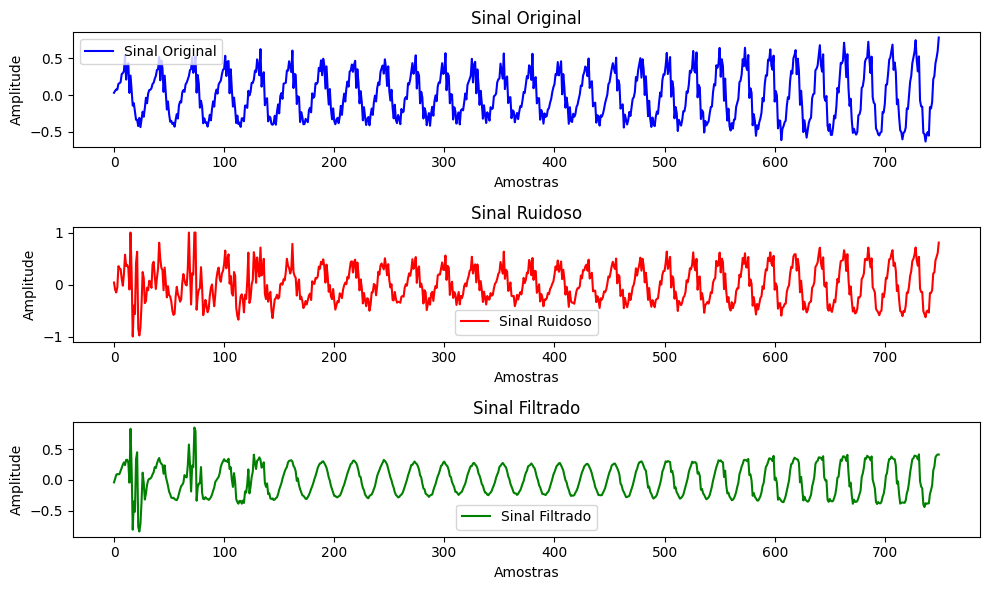

In [15]:
index = 3
start = 2500
end = start + 750

# Plote o sinal original e o sinal do LPC gerado
plt.figure(figsize=(10, 6))

# Plote o sinal original
plt.subplot(3, 1, 1)
plt.plot(y_batch[index][start:end], label='Sinal Original', color='blue')
plt.title('Sinal Original')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()

# Plote o sinal do LPC gerado
plt.subplot(3, 1, 2)
plt.plot(x_batch[index][start:end], label='Sinal Ruidoso', color='red')
plt.title('Sinal Ruidoso')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()

# Plote o sinal do LPC gerado
plt.subplot(3, 1, 3)
plt.plot(filtered_batch[index][start:end], label='Sinal Filtrado', color='green')
plt.title('Sinal Filtrado')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
from datetime import datetime

In [13]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Define the file name with the datetime
file_name = f"wiener_{datetime_str}.xlsx"

In [14]:
df_resultado.to_excel(file_name, index=False)